<a href="https://colab.research.google.com/github/jonaden94/deepl-ecker-21-22/blob/main/Ex2_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise Sheet 2 - CIFAR, MLP, Overfitting, and Regularization

 * Deep Learning – Winter term 2021/22
 * Instructors: Alexander Ecker, Max Burg, Laura Pede
 * Due date: **Tue, Nov 23, 12:00**


## Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**


## Topic

In this exercise sheet, you will:
- get to know a new dataset: CIFAR-10
- implement a MLP
- get more familiar with model fitting
- see overfitting
- implement early stopping
- explore hyperparameters and their influence
- vary architecture to improve model performance

*We are looking forward to seeing your solutions! Have fun!*


## Important submission instructions

- **You need to answer all questions in written form!**
- When you're done, download the notebook and rename it to `<surname1>_<surname2>_<surname3>.ipynb`
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient
- Do not change the cells which are marked as "Do not change", similarly write your solution into the marked cells.


## Imports

In [162]:
import os
import fastprogress
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader

### GPU and Cuda checks

In [ ]:
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print('cuda available:', torch.cuda.is_available(), 
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

In [163]:
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla K80
2 CPUs available


**Recommendation:** Use GPU or TPU for faster model training. Exercise sheet 1 explains how to do that on Colab.

## Load data

In [164]:
def grab_data(data_dir, num_cpus=1):
    """Downloads CIFAR10 train and test set, stores them on disk, computes mean 
        and standard deviation per channel of trainset, normalizes the train set
        accordingly.

    Args:
        data_dir (str): Directory to store data
        num_cpus (int, optional): Number of cpus that should be used to 
            preprocess data. Defaults to 1.

    Returns:
        CIFAR10, CIFAR10, float, float: Returns trainset and testset as
            torchvision CIFAR10 dataset objects. Returns mean and standard
            deviation used for normalization.
    """
    trainset = torchvision.datasets.CIFAR10(data_dir, train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())

    # Get normalization transform
    num_samples = trainset.data.shape[0]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=num_samples, 
                                              num_workers=num_cpus)
    imgs, _ = next(iter(trainloader))
    dataset_mean = torch.mean(imgs, dim=(0,2,3))
    dataset_std = torch.std(imgs, dim=(0,2,3))

    normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(dataset_mean, dataset_std)
    ])

    # Load again, now normalized
    trainset = torchvision.datasets.CIFAR10(data_dir, download=True, train=True, 
                                            transform=normalized_transform) 
    # Apply the same transform, computed from the train-set, to the test-set
    # so both have a similar distribution. We do not normalize the test-set directly,
    # since we are not allowed to perform any computations with it. (We only use it
    # for reporting results in the very end)
    testset = torchvision.datasets.CIFAR10(data_dir, download=True, train=False, 
                                           transform=normalized_transform)

    return trainset, testset, dataset_mean, dataset_std
        
        
def generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2):
    """Splits train dataset into train and validation dataset.

    Args:
        trainset (CIFAR10): CIFAR10 trainset object
        split_seed (int, optional): Seed used to randomly assign data
            points to the validation set. Defaults to 42.
        val_frac (float, optional): Fraction of training set that should be 
            split into validation set. Defaults to 0.2.

    Returns:
        CIFAR10, CIFAR10: CIFAR10 trainset and validation set.
    """
    num_val_samples = np.ceil(val_frac * trainset.data.shape[0]).astype(int)
    num_train_samples = trainset.data.shape[0] - num_val_samples
    trainset, valset = torch.utils.data.random_split(trainset, 
                                  (num_train_samples, num_val_samples), 
                                  generator=torch.Generator().manual_seed(split_seed))
    return trainset, valset
    
    
def init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=1):
    """Initialize train, validation and test data loader.

    Args:
        trainset (CIFAR10): Training set torchvision dataset object.
        valset (CIFAR10): Validation set torchvision dataset object.
        testset (CIFAR10): Test set torchvision dataset object.
        batch_size (int, optional): Batchsize that should be generated by 
            pytorch dataloader object. Defaults to 1024.
        num_cpus (int, optional): Number of CPUs to use when iterating over
            the data loader. More is faster. Defaults to 1.

    Returns:
        DataLoader, DataLoader, DataLoader: Returns pytorch DataLoader objects
            for training, validation and testing.
    """        
    trainloader = torch.utils.data.DataLoader(trainset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_cpus)
    valloader = torch.utils.data.DataLoader(valset, 
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=num_cpus)
    testloader = torch.utils.data.DataLoader(testset,
                                                  batch_size=batch_size,
                                                  shuffle=True, 
                                                  num_workers=num_cpus)
    return trainloader, valloader, testloader

#### TODO
- Load the CIFAR 10 train and test data set using the functions defined above
- Generate a validation set from 20% of the training set samples. *Remember:* Keep the seed for the validation set generation fixed for reproducibility.
- Generate torch data loaders for the train, validation and test data set splits. Use a batch size of 1024.

*Hint:* we will use the mean and standard deviation returned by ```grab_data``` later

In [165]:
####################
## YOUR CODE HERE ##
####################
trainset, testset, mean, std = grab_data(data_dir = "data")
trainset, valset = generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2)
trainloader, valloader, testloader = init_data_loaders(trainset, valset, testset, batch_size=1024)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Let's have a look at the dataset.

#### TODO
- Print all class names
- Plot 16 images randomly drawn from the training set with their according class label

*Hint:* Since you normalized the dataset before, you have to undo that operation for plotting

In [166]:
def imshow(img, mean, std):
    """Undo normalization using mean and standarddeviation and show image.

    Args:
        img (torch.Tensor): Image to show
        mean (np.array shape (3,)): Vector of means per channel used to
            normalize the dataset.
        std (np.array shape (3,)): Vector of standard deviations per channel 
            used to normalize the dataset.
    """
    ####################
    ## YOUR CODE HERE ##
    ####################
    # Define function to plot
    img = img * std[:,None,None] + mean[:,None,None]


    return img.permute((1,2,0))


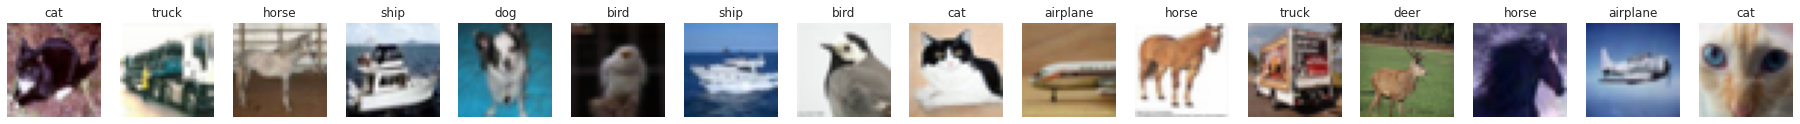

In [167]:
####################
## YOUR CODE HERE ##
####################
# Create actual plot and print the class names
n = 16
classes = trainset.dataset.classes
fig, axes = plt.subplots(1, n, figsize=(2*n, 2))
for ax in axes.ravel():
    rand = np.random.randint(0, len(trainloader.dataset))
    ax.set_title("{}".format(classes[trainloader.dataset[rand][1]]))
    ax.axis('off')
    ax.imshow(imshow(trainloader.dataset[rand][0], mean, std))

## Training, evaluation and plotting functions from Exercise 1

Here, we provide examples of the functions you implemented on the first exercise sheet to you. Some parts are still missing. You can ignore that for the time being, as you will implement that later as soon as the according functionality is required.

In [186]:
def accuracy(correct, total): 
    """Compute accuracy as percentage.

    Args:
        correct (int): Number of samples correctly predicted.
        total (int): Total number of samples

    Returns:
        float: Accuracy
    """
    return float(correct)/total


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix


def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
        
        # custom code for early stopper
        if not early_stopper == None:

            if epoch >= 2:
                early_stopper.early_stopping(train_accs[-2] > train_accs[-1])

            if early_stopper.early_stop:
                time_elapsed = np.round(time.time() - start_time, 0).astype(int)
                print(f'stoped early after {time_elapsed} seconds and in epoch {epoch}')
                return train_losses, val_losses, train_accs, val_accs, confusion_matrix
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix

def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        ####################
        ## YOUR CODE HERE ##
        ####################
        raise NotImplementedError

        # END OF YOUR CODE #
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

## MLP model

#### TODO
- Define an MLP model implementing all the functionality indicated by the parameters and the docstrings
- There should be a non-linearity after the input layer and in the hidden layers, i.e. in all layers that map to hidden units, but not in the final (linear) layer that creates the outputs

*Hint*: As CIFAR 10 is a color image, amongst other dimensions you want to flatten the color channel dimension, too.

In [170]:
class MLP(nn.Module):
    """Multi layer perceptron torch model."""
    def __init__(self, img_width, num_in_channels, num_classes, 
                 num_hidden_units=30, num_hidden_layers=1, act_fn=None):
        """Initialize model.

        Args:
            img_width (int): Width of images
            num_in_channels (int): Number of input channels of images
            num_classes (int): Number of classes to predict
            num_hidden_units (int, optional): Number of hidden units per layer. 
                Defaults to 30.
            num_hidden_layers (int, optional): Number of hidden layers. Total
                number of layers will be num_hidden_layers + 2. Defaults to 1.
            act_fn (nn activation function, optional): Activation function
                to use after the first and all the hidden layers. If None, use
                nn.ReLU(). Defaults to None.
        """
        ####################
        ## YOUR CODE HERE ##
        ####################

        super().__init__()
        self.flatten = nn.Flatten()
        self.layer_in = nn.Linear(img_width * img_width * num_in_channels, num_hidden_units)
        self.layer_mid = nn.Linear(num_hidden_units, num_hidden_units)
        self.layer_out = nn.Linear(num_hidden_units, num_classes)
        self.relu = act_fn
        self.num_hidden_layers = num_hidden_layers
    
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """
        ####################
        ## YOUR CODE HERE ##
        ####################

        x = self.flatten(x)
        x = self.relu(x)
        x = self.layer_in(x)

        for i in range(self.num_hidden_layers-1):
            x = self.relu(x)
            x = self.layer_mid(x)
            
        x = self.relu(x)
        outputs = self.layer_out(x)
        return outputs

## Model training: learning rate

One of the most important hyperparameters is the learning rate. If we set it incorrectly, our model might not train at all, take very long time to train, or lead to suboptimal performance. Thus, we should make sure to set it appropriately.

So with what learning rate should we start? Usually, you would start setting a very high learning rate, e.g. ```lr = 1e0``` and then decrease it by a factor of ten until the model starts to converge. Since we might have to try multiple values here, it is sufficient to train only a few iterations to see if the model trains at all. As soon as we find a learning rate that works, we train for more epochs to get a well performing model.

For optimization, we do not use SGD as in exercise 1, but the commonly used Adam optimizer, since it behaves very robustly and is easy to use.

#### TODO
- Instantiate a MLP model with one hidden layer and ReLU activation function 
- Train the model for 10 epochs
- Use the Adam optimizer
- Start with a learning rate of $10^0$, then decrease the learning rate logarithmically, i.e. by a factor of 10, until your model starts to train
- Plot the training curves of the loss and the accuracies as in exercise 1. Use the functions defined above.

*Hints:*

In [187]:
mlp = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_units=30, 
          num_hidden_layers=1, act_fn=nn.ReLU(inplace=False))

mlp = mlp.cuda()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1)
loss_function = nn.CrossEntropyLoss()


result1 = run_training(mlp, optimizer, loss_function, device, 10, 
                      trainloader, valloader, early_stopper=EarlyStopper(), verbose=True)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73a204b560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73a204b560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

stoped early after 89 seconds and in epoch 5


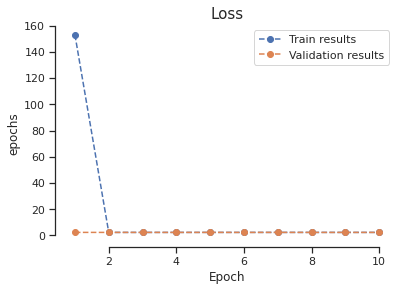

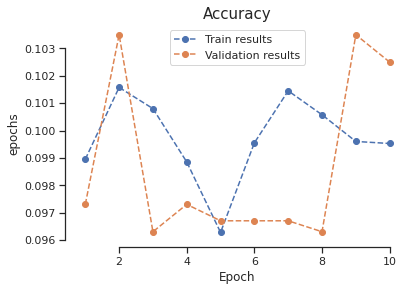

In [175]:
train_losses, val_losses, train_accs, val_accs, confusion_matrix = result1
plot("Loss", "epochs", train_losses, val_losses, yscale='linear')
plot("Accuracy", "epochs", train_accs, val_accs, yscale='linear')

In [176]:
mlp = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_units=30, 
          num_hidden_layers=1, act_fn=nn.ReLU(inplace=False))

mlp = mlp.cuda()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.1)
result2 = run_training(mlp, optimizer, loss_function, device, 10, 
                      trainloader, valloader, early_stopper=None, verbose=True)

KeyboardInterrupt: ignored

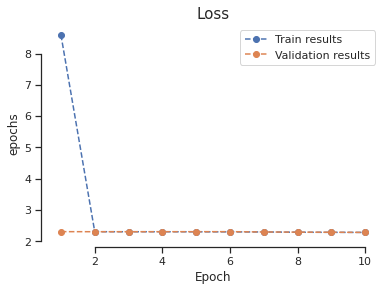

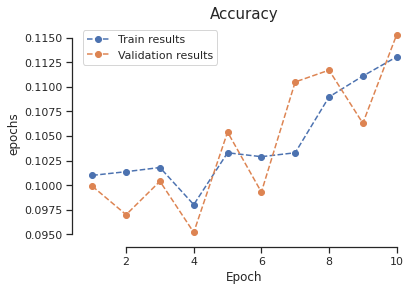

In [ ]:
train_losses, val_losses, train_accs, val_accs, confusion_matrix = result2
plot("Loss", "epochs", train_losses, val_losses, yscale='linear')
plot("Accuracy", "epochs", train_accs, val_accs, yscale='linear')

In [ ]:
mlp = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_units=30, 
          num_hidden_layers=1, act_fn=nn.ReLU(inplace=False))

mlp = mlp.cuda()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
result3 = run_training(mlp, optimizer, loss_function, device, 10, 
                      trainloader, valloader, early_stopper=None, verbose=True)

Finished training after 146 seconds.


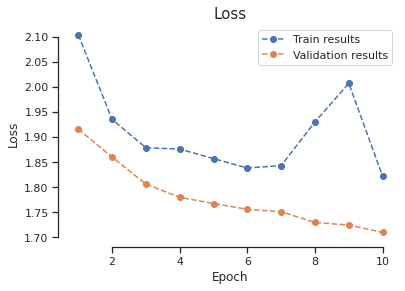

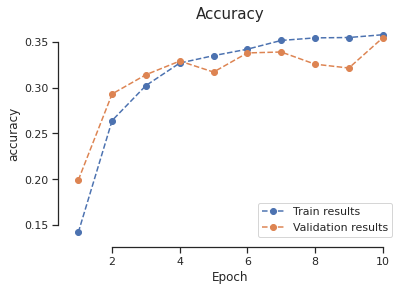

In [ ]:
train_losses, train_losses, train_accs, val_accs, confusion_matrix = result3
plot("Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("Accuracy", "accuracy", train_accs, val_accs, yscale='linear')

In [ ]:
mlp = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_units=30, 
          num_hidden_layers=1, act_fn=nn.ReLU(inplace=False))

mlp = mlp.cuda()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
result4 = run_training(mlp, optimizer, loss_function, device, 10, 
                      trainloader, valloader, early_stopper=None, verbose=True)

Finished training after 147 seconds.


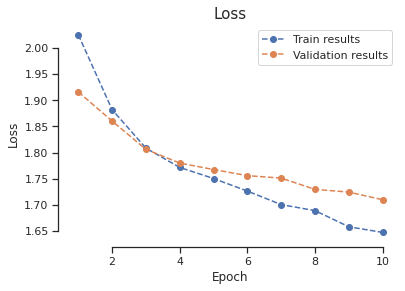

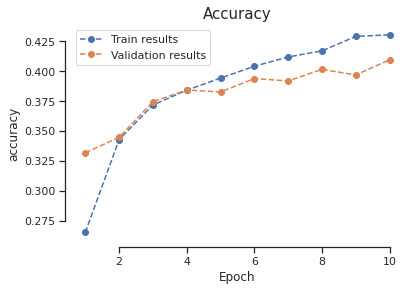

In [ ]:
train_losses, val_losses, train_accs, val_accs, confusion_matrix = result4
plot("Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("Accuracy", "accuracy", train_accs, val_accs, yscale='linear')

In [ ]:
mlp = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_units=30, 
          num_hidden_layers=1, act_fn=nn.ReLU(inplace=False))

mlp = mlp.cuda()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001)
result5 = run_training(mlp, optimizer, loss_function, device, 10, 
                      trainloader, valloader, early_stopper=None, verbose=True)


Finished training after 149 seconds.


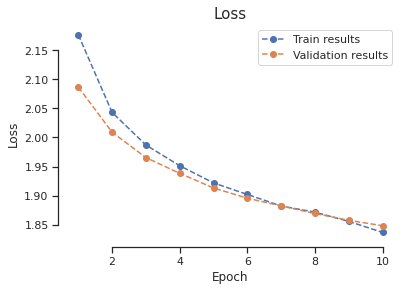

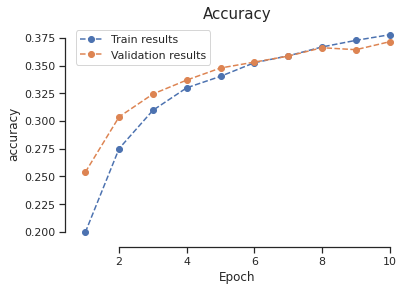

In [ ]:
train_losses, val_losses, train_accs, val_accs, confusion_matrix = result5
plot("Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("Accuracy", "accuracy", train_accs, val_accs, yscale='linear')

**This is an example of a model that does not train sufficiently:** *(Why?)*

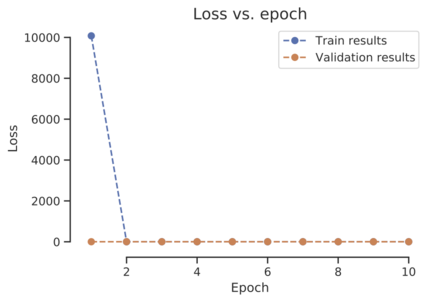

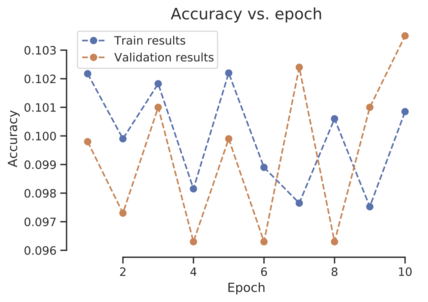

**This is an example of a model that does train:** *(Why?)*

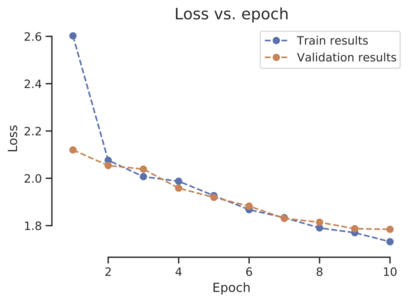

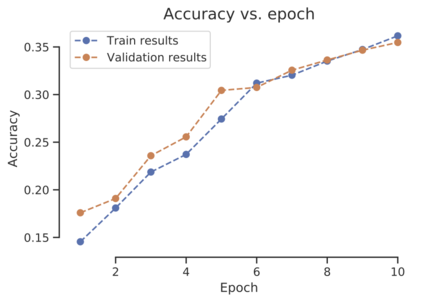

Has your model already converged, i.e. reached the highest accuracy on the validation set? Probably not. So here are your todo's:

#### TODO:
- Train the model for 100 epochs (this might take approx. 30 min depending on your GPU)

#### TODO from now on, for all subsequent tasks:
- Print the overall best value and the epoch at which it occurred of:
    - val loss and
    - val accuracy

In [ ]:
####################
## YOUR CODE HERE ##
####################
mlp = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_units=30, 
          num_hidden_layers=1, act_fn=nn.ReLU(inplace=False))

mlp = mlp.cuda()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
result5 = run_training(mlp, optimizer, loss_function, device, 100, 
                      trainloader, valloader, early_stopper=None, verbose=False)


Finished training after 1391 seconds.


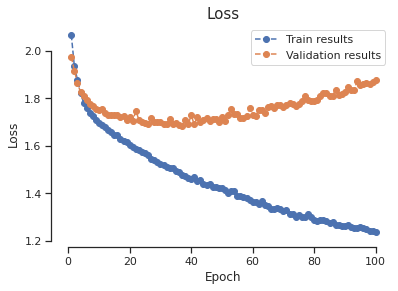

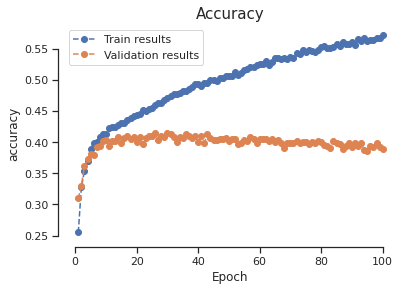

epoch 25 0.4141
epoch 36 1.6822736859321594


In [ ]:
train_losses, val_losses, train_accs, val_accs, confusion_matrix = result5
plot("Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("Accuracy", "accuracy", train_accs, val_accs, yscale='linear')


def diag():
    print("epoch", np.argmax(val_accs), np.max(val_accs))
    print("epoch", np.argmin(val_losses), np.min(val_losses))
diag()

Let's have a look at those training curves! Here are some questions for you.

Answer the following questions in written form, as they are really crucial for the rest of this course.

1. Does the training loss decrease after each epoch? Why does it? // Why does it not?
1. Does the validation loss decrease after each epoch? Why does it? // Why does it not? (For your answer to be sufficient, you should describe fluctuations and discuss the overall minimum of the curve.)
1. Do the training and validation accuracy increase after each epoch? Why? // Why not?
1. Are the epochs at which you got the best validation loss and the best validation accuracy the same?
1. (Optional): Do you have any ideas why not?
1. At which epoch was your model best? I.e. if you had saved your model after each training epoch, which one would you use to make predictions to unseen samples (e.g. from the test set)? Why? (For your answer to be sufficient: Also discuss what this means in terms of overfitting)

#### Your answers:
1. the training loss should generally decrease, but it can also increase randomly. One reason can be the specific characteristics of individual batches. Also if the loss function has a very uneven surface, i. e. possibly next to a minimum after many epochs, the training loss can increase.
2. If the training loss does not decrease of course the validation loss also does also not need to decrease. The fluctuations in the loss explained as uneven surface in 1. also applies here. Regarding the overall minimum, if we should already have reached an overall minimum of the loss, we can obviously not reduce the loss anymore.

We are unsure how much the uneven surface and the batch effects play a role. Could you rate them?
3. For the Training and validation accuracy the same as for the loss applies and they do not necessarily increase in each epoch, however they tend to fluctuate less, because for the classification to change a more significant change in the output value needs to occur than for the loss to change.
45. No. But it does not need to be same, because the accuracy only indicates the max label, while the loss is determined by the probability values, containing more data.
6. in epoch 25 we had the best validation acc. We should use the epoch with the best validation accuracy or validation loss. We would not use the last epoch or the epoch with the best training acc, because these values can be better since the parameters are overfitted, that means they learned characteristics of the training data, which do not generalize to other data.

## Save and restore model checkpoints

Training that model for 100 epochs took quite a bit of time, right? Wouldn't it be a pity if it would get deleted out of memory, e.g. because your Colab session terminates (this can even happen automatically)? We would have to train it again to make predictions! To prevent this, we would like to save a check-point of the already optimized model's weights to disk. Then, we could just load our model weights at any time and use our model again without retraining. As you will see in a bit, this will be very handy for early stopping, too!

#### TODO
- Save a checkpoint of the `model` trained above (i.e. the model's parameters) to disk
- Initialize a new model, `model2` with the same architecture as used for the `model` you stored. Do *not* train `model2`.
- Compute `model2`'s validation set accuracy. *Hint:* You can use the validation function from above. As a parameter, you would have to set `master_bar=None` since there is no progress bar for epochs in this setting.
- Now, overwrite the initialized, untrained weights of `model2` with the weights you saved into the checkpoint of `model`.
- Evaluate `model2`'s validation set accuracy again. It should be of the exact same value as `model`'s validation set accuracy.

*Hints:*
- Read https://pytorch.org/tutorials/beginner/saving_loading_models.html
- Use `model.state_dict()`

In [ ]:
torch.save(mlp.state_dict(), "saved_model_100epochs")

# new model
mlp2 = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_units=30, 
          num_hidden_layers=1, act_fn=nn.ReLU(inplace=False))
mlp2 = mlp2.cuda()
mlp2.eval()
loss, acc, conf = validate(valloader, mlp2, loss_function, device, master_bar=None)
print(acc)

state_dict = torch.load("saved_model_100epochs")
mlp2.load_state_dict(state_dict)
mlp2.eval()
loss, acc, conf = validate(valloader, mlp2, loss_function, device, master_bar=None)
print(acc)

0.1151


0.3892


## Early stopping

So the model you ended up with after 100 epochs was not the best one. That has two implications for us: (1) We would not have had to train for that many epochs and could have saved some computing time. (2) We do not have the best model to apply our model to make actual predictions for unseen samples. If we would constantly assess our model's validation performance during training, we could stop optimization as soon as our model's performance does not increase anymore. This is called *early stopping*.


#### TODO:
- Implement the `EarlyStopper` class below
- Modify `def run_training(...)` above such that it updates the `EarlyStopper` after each training epoch. Stop training as soon as the validation accuracy did not increase anymore. Then, load the model checkpoint of the previous epoch (i.e. your best model)

In [ ]:
tart_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
        
        # custom code for early stopper
        if not early_stopper == None:
            early_stopper.update(val_accs)
            
            if early_stopper.stop:
                time_elapsed = np.round(time.time() - start_time, 0).astype(int)
                print(f'stoped early after {time_elapsed} seconds and in epoch {epoch}')
                return train_losses, val_losses, train_accs, val_accs, confusion_matrix
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix

In [178]:
class EarlyStopper:
    """Early stops the training if validation accuracy does not increase after a
    given patience. Saves and loads model checkpoints.
    """
    def __init__(self, verbose=False, path='checkpoint.pt'):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
        """
        self.early_stop = False
        self.path = path

    @property
    def early_stop(self):
        return self._early_stop

    @early_stop.setter
    def early_stop(self, increase, model):
       if increase:
           self._early_stop = False
       else:
           self._early_stop = True


In [181]:
class EarlyStopper:
    """Early stops the training if validation accuracy does not increase after a
    given patience. Saves and loads model checkpoints.
    """
    def __init__(self, verbose=False, path='checkpoint.pt'):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
        """
        self.early_stop = False

    def early_stop(self, accuracy):
        """True if early stopping criterion is reached.

        Returns:
            [bool]: True if early stopping criterion is reached.
        """
        if accuracy[-2] > accuracy[-1]:
            return True
        return False
    
    def update(self, accuracy):
        """
        saves checkpoint and updates early stop attribute
        """
        self.early_stop = self.early_stop(accuracy)
        if not self.early_stop:
            torch.save(model.state_dict(), "checkpoint.pt")

In [182]:
class EarlyStopper:
    """Early stops the training if validation accuracy does not increase after a
    given patience. Saves and loads model checkpoints.
    """
    def __init__(self, verbose=False, path='checkpoint.pt'):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
        """
        self.early_stop = False
        self.path = path


    def early_stopping(self, increase):
       if increase:
           self.early_stop = False
       else:
           self.early_stop = True

#### TODO:
- Train a MLP model (same architecture, optimization, etc. as you used before)
- Set `num_epochs = 100`
- Use your `EarlyStopper` to stop training early, after validation accuracy did not increase for one epoch (see description in TODOs above)

#### TODO here and for all subsequent exercises:
- In the training plots you create, mark the validation accuracy point of the model you end up with after stopping your training early. To do so, you can implement the missing functionality in `def plot(...)` above.

In [ ]:
####################
## YOUR CODE HERE ##
####################



#### TODO
- Compare the training you just did with the one of the same model trained for 100 epochs. Did you reach best model performance? If so: why? If not: why not?
- Implement a patience functionality into `EarlyStopper`: stop model training, if validation accuracy did not increase for `patience` epochs. You are allowed to add more arguments to `EarlyStopper.__init__`.
- Do the same training as in the previous cell, starting training from scratch, but try different values for `patience` now. Did you end up with a model resulting in the best validation accuracy you have seen so far, but without training the full 100 epochs?

In [ ]:
####################
## YOUR CODE HERE ##
####################



## Which learning rate is best?

Now that we have a learning strategy that works well, let us explore the effect of the learning rate on training and model performance.

#### TODO:
- Run training again as above, but with learning rate decreased by one order of magnitude, i.e. `lr = 1e-3`
- Run training again as above, but now with even smaller learning rate, `lr = 1e-4`
- What do you observe in terms of model accuracy? How long did it take to train these models? Which learning rate would you choose for any subsequent experiments you could do?

In [ ]:
lr = 1e-3

####################
## YOUR CODE HERE ##
####################



In [ ]:
lr = 1e-4

####################
## YOUR CODE HERE ##
####################



## Explore batch size *(optional)*

*This task is optional, you do not need to solve it*

Let us explore even more model and training parameters. In this section, we will see the impact of batch size on training. Let us use a learning rate of $10^{-3}$ from now on.


#### TODO *(optional)*
- Run training of the same model used above with 
    - batch size 1 for **one epoch**
    - batch size 512 for 100 epochs, using early stopping with patience 10
- Compare your training results of all three batch sizes you have trained, i.e. batch size 1, 512 and 1024 (from above)
- Was it smart to set batch size to 1?
- How long (in terms of computing time) do your models need to train for the different batch sizes? (You could even measure this with python, using the `time` package)
- What is the impact on model performance?

*Hint*: You have to initialize new data loaders, as they provide you with batches during training.

In [ ]:
# Batch size 1

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################



In [ ]:
# Batch size 512

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################



# What about the architecture?

How does architecture affect predictive performance? 

#### TODO:
In the following, try to improve model performance by varying 
- number of  hidden units
- number of layers
- activation function used

These parameters are called hyper-parameters, since they are excluded from model optimization. Instead, we have to set them by hand and explore them to find a model with good predictive accuracy. 

Vary only one hyper-parameter at a time. If you would vary multiple parameters at the same time, it would be harder for you to see the impact that each parameter has.

In [ ]:
# number of hidden units

####################
## YOUR CODE HERE ##
####################



In [ ]:
# number of layers

####################
## YOUR CODE HERE ##
####################



In [ ]:
# activation function

####################
## YOUR CODE HERE ##
####################



#### Questions
- How good do you get?
- Which hyper-parameter makes the largest difference?
- Does it always help to make your model bigger (i.e. wider / deeper)? Why not?



**Your answers:**
- ...

Now, here are more TODO's, questions and a little challenge for you: 

#### TODO
- If you choose your best values for number hidden units, number of layers and activation function that you determined by varying them independently above: Does performance improve? Why?
- Vary all of the parameters at the same time to maximize the predictive performance of your model. How good do you get?
    - When creating the exercise, I got a validation accuracy of 57%
    - Surpassing 50% val. acc. should be possible for you

In [ ]:
# Your best model:

####################
## YOUR CODE HERE ##
####################



#### Questions:
- If you train the same model multiple times from scratch: do you get the same performance? Are the models you trained above comparable then?
- What could we do about this?
    - *Hint:* there are actually multiple answers to this question. 
    - One could be to change model training and evaluation. How?
    - The other could be to use a more sophisticated analysis. How?

# Evaluate your best model on test set, once!

When doing a study, at the very end right before writing up your paper, you evaluate the best model you chose on the test set. This is the performance value you will report to the public.

#### TODO
- What is the accuracy of the best model you found on the test set?
- Plot the confusion matrix, too! *(optional)*

In [ ]:
def test(test_loader, model, device):
    """Compute accuracy and confusion matrix on test set.

    Args:
        test_loader (DataLoader): torch DataLoader of test set
        model (nn.Module): Model to evaluate on test set
        device (torch.device): Device to use

    Returns:
        float, torch.Tensor shape (10,10): Returns model accuracy on test set
            (percent classified correctly) and confusion matrix
    """
    ####################
    ## YOUR CODE HERE ##
    ####################


In [ ]:
####################
## YOUR CODE HERE ##
####################



#### Questions:
- On which classes is your model's prediction poor?
- Is the test accuracy of your model as good as the validation accuracy?
- If those values are different: How can you explain the difference?
- Why should you never use test set performance when trying out different hyper-parameters and architectures?